In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [2]:
df=pd.read_csv("Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
df.shape

(150, 6)

In [7]:
df.nunique()

Id               150
SepalLengthCm     35
SepalWidthCm      23
PetalLengthCm     43
PetalWidthCm      22
Species            3
dtype: int64

In [3]:
df.drop("Id",axis=1,inplace=True)# it adds no value to the model.

In [9]:
df.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

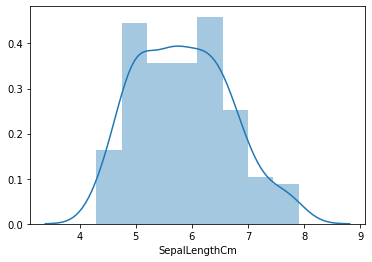

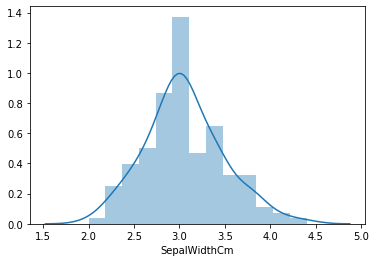

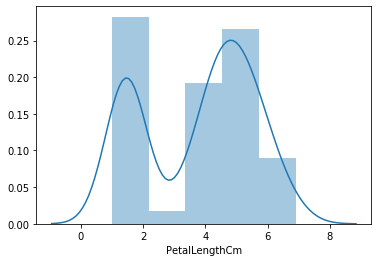

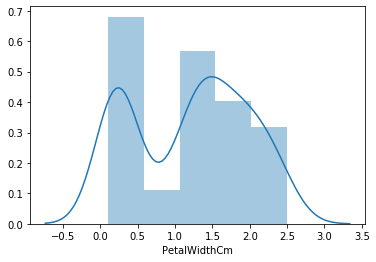

In [14]:
for i in ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']:
    sns.distplot(df[i])
    plt.show()

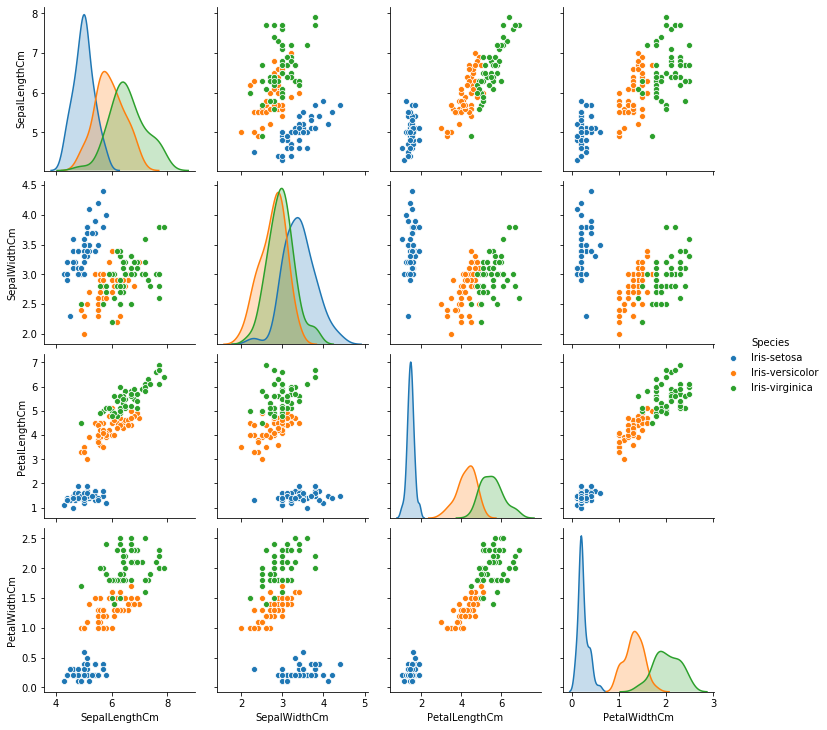

In [35]:
sns.pairplot(df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species']],hue="Species")
plt.show()

In [4]:
sc=StandardScaler()
xsc=pd.DataFrame(sc.fit_transform(df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]),columns=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm'])
xsc.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


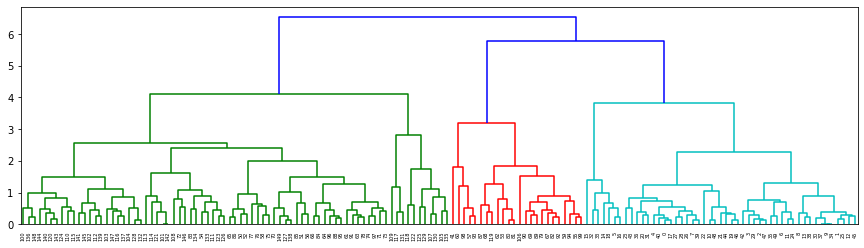

In [5]:
# Determining the correct number of clusters from the dendrogram:

from scipy.cluster.hierarchy import dendrogram,linkage,cut_tree

links=linkage(xsc,method="complete",metric="euclidean")

plt.figure(figsize=(15,4))

dendrogram(links)

plt.show()
    


#### From above, we can see 3 different clusters.

In [6]:
cutting_tree=cut_tree(links,n_clusters=3).reshape(-1,1)
cutting_tree[0:15]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [7]:
df["agglomerative_clusters"]=cutting_tree

In [8]:
pd.crosstab(df["Species"],df.agglomerative_clusters) # 3 cluster solution seems to be apt

agglomerative_clusters,0,1,2
Species,,,
Iris-setosa,49,1,0
Iris-versicolor,0,21,29
Iris-virginica,0,2,48


In [10]:
# Validating the 3 cluster solution with an elbow graph and by checking the silhoutte score 

from sklearn.metrics import silhouette_samples,silhouette_score

In [12]:
silhouette_score(xsc,cutting_tree.ravel()) # This is the avg silhoutte score of all the clusters

0.4487911772434676

In [13]:
df["Silhoutte_score_of_point"]=silhouette_samples(xsc,df.agglomerative_clusters)

In [15]:
df.groupby("agglomerative_clusters").mean()["Silhoutte_score_of_point"] 
# Silhoutte score of the 3rd cluster is not greater than the avg. Silhoutte score of all the samples

agglomerative_clusters
0    0.641597
1    0.477920
2    0.317017
Name: Silhoutte_score_of_point, dtype: float64

#### Let's implement the same thing with kmeans. To decide the number of clusters, let's plot the elbow graph

In [16]:
from sklearn.cluster import KMeans

ssd=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,random_state=5)
    kmeans.fit(xsc)
    ssd.append(kmeans.inertia_)
    

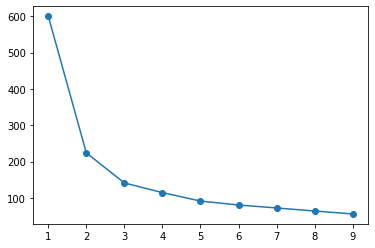

In [17]:
plt.plot(range(1,10),ssd,marker="o")
plt.show()

In [18]:
Elbow seems to be at 3

In [23]:
ssd

[600.0,
 223.73200573676345,
 140.96581663074699,
 114.38847745657692,
 91.10993320471393,
 80.23060704506958,
 72.1057774877246,
 63.663008486997384,
 55.69408774309419]

In [27]:
for i in range(len(ssd)-1):
    print(f'SSD dropped by {ssd[i]-ssd[i+1]} when cluster changed from {i+1} to {i+2}',end="\n\n")
  

SSD dropped by 376.2679942632366 when cluster changed from 1 to 2

SSD dropped by 82.76618910601647 when cluster changed from 2 to 3

SSD dropped by 26.577339174170064 when cluster changed from 3 to 4

SSD dropped by 23.278544251862996 when cluster changed from 4 to 5

SSD dropped by 10.87932615964435 when cluster changed from 5 to 6

SSD dropped by 8.124829557344981 when cluster changed from 6 to 7

SSD dropped by 8.44276900072721 when cluster changed from 7 to 8

SSD dropped by 7.9689207439031975 when cluster changed from 8 to 9



#### Let's get the clusters with KMEANS

In [28]:
kmeans=KMeans(n_clusters=3,random_state=5)
kmeans.fit(xsc)
df["kmeans_cluster_labels"]=kmeans.labels_

In [29]:
pd.crosstab(df.Species,df.kmeans_cluster_labels)

kmeans_cluster_labels,0,1,2
Species,,,
Iris-setosa,0,50,0
Iris-versicolor,39,0,11
Iris-virginica,14,0,36


In [30]:
kmeans.inertia_

140.96581663074699

In [32]:
df["silhoutte_coff_kmeans"]=silhouette_samples(xsc,df.kmeans_cluster_labels)

In [33]:
silhouette_score(xsc,df.kmeans_cluster_labels)

0.4589717867018717

In [34]:
df.groupby("kmeans_cluster_labels").mean()["silhoutte_coff_kmeans"] 

kmeans_cluster_labels
0    0.393002
1    0.633730
2    0.347450
Name: silhoutte_coff_kmeans, dtype: float64

#### Class 2 still has silhoutte score greater than the avg. Silhoutte score. From the dataset, we know that there are 3classes. However, from the pairploot we see that all the features are very much overlapping for versicolor and verginica. Therefore we are sure that the cluster is not very efficient in predicting these 2 classes. Setosa is distinct from the other varieties in every aspect . Hence, it is clustered correctly with hardly any error.